In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.preprocessing import QuantileTransformer
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, roc_curve, f1_score
#,roc_curve, precision_recall_curve, auc, make_scorer, precision_score

#some models
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier


%matplotlib inline

In [2]:
offers_classed=pd.read_pickle("final_table.pkl")

Calling the table off holding all the data 'offers_classed'

In [3]:
offers_classed.head()

,person,time,offer_id,reward,difficulty,duration,successful_offer,mobile,social,web,bogo,discount,informational,age,became_member_on,income,female,male,other
0,0009655768c64bdeb2e877511632db8f,168.0,5a8bc65990b245e5a138643cd4eb9837,0.0,0.0,3.0,1.0,1.0,1.0,0.0,0,0,1,33,1492732800000000000,72000.0,0,1,0
1,0009655768c64bdeb2e877511632db8f,336.0,3f207df678b143eea3cee63160fa8bed,0.0,0.0,4.0,1.0,1.0,0.0,1.0,0,0,1,33,1492732800000000000,72000.0,0,1,0
2,0009655768c64bdeb2e877511632db8f,408.0,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,5.0,0.0,1.0,1.0,1.0,1,0,0,33,1492732800000000000,72000.0,0,1,0
3,0009655768c64bdeb2e877511632db8f,504.0,fafdcd668e3743c1bb461111dcafc2a4,2.0,10.0,10.0,0.0,1.0,1.0,1.0,0,1,0,33,1492732800000000000,72000.0,0,1,0
4,0009655768c64bdeb2e877511632db8f,576.0,2906b810c7d4411798c6938adc9daaa5,2.0,10.0,7.0,0.0,1.0,0.0,1.0,0,1,0,33,1492732800000000000,72000.0,0,1,0


In [4]:
labels=offers_classed['successful_offer'].values
print(len(labels))

66501


In [5]:
#labels=labels.astype('bool')

In [6]:
features = offers_classed.filter(['reward', 'difficulty', 'duration','mobile', 'social', 'web', 'bogo', 'discount',
                 'informational', 'age', 'became_member_on', 'income',   'female', 'male', 'other']).values
print(len(features))

66501


In [7]:
labels

array([1., 1., 0., ..., 1., 0., 0.])

In [8]:
features

array([[ 0.,  0.,  3., ...,  0.,  1.,  0.],
       [ 0.,  0.,  4., ...,  0.,  1.,  0.],
       [ 5.,  5.,  5., ...,  0.,  1.,  0.],
       ...,
       [ 2., 10.,  7., ...,  1.,  0.,  0.],
       [ 5.,  5.,  7., ...,  1.,  0.,  0.],
       [ 2., 10.,  7., ...,  1.,  0.,  0.]])

I will use a quantile transformer to scale all my features. It is robust at handling outliers and skewed data.

In [9]:
def scale_split(features,labels):
    
    #split the features and labels into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(features, labels, train_size=0.80, random_state=40)

    #fit and transform scaling on training data
    scaler=QuantileTransformer()
    
    #scale the features separately so there is no data leak between the training set and test set
    X_train=scaler.fit_transform(X_train)
    X_test=scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test

In [10]:
features_train, features_test, labels_train, labels_test=scale_split(features, labels)
features_train[0]

array([0.65065065, 0.2997998 , 0.2987988 , 1.        , 1.        ,
       1.        , 1.        , 0.        , 0.        , 0.2032032 ,
       0.98498498, 0.54004004, 0.        , 1.        , 0.        ])

In [12]:
print('the size of the train set is: {}.'.format(len(features_train)))
print('the size of the test set is: {}.'.format(len(features_test)))

the size of the train set is: 53200.
the size of the test set is: 13301.


<font size=4>Some initial basic models to see how good they are at predicting<font/>

Decision Tree Classifier with default parameters

In [14]:
def classifyDecisionTree(features_train, labels_train, features_test, labels_test):
    
    #create the classifer
    clf = DecisionTreeClassifier(random_state=40)
    
    #fit the training data
    clf = clf.fit(features_train, labels_train)
    
    #predict the testing labels using the testing features
    pred=clf.predict(features_test)
    
    #evaluate how good the model did at predicting the true teting labels
    print(classification_report(labels_test, pred,digits=4, target_names=['unsuccessful','successful'],output_dict=False))
    
    #printing the confusion matrix
    con_mat=pd.DataFrame(confusion_matrix(labels_test, pred),  columns=['pred_neg', 'pred_pos'], index=['neg', 'pos'])
    plt.figure(figsize = (4,4))
    sn.heatmap(con_mat, annot=True,cmap='YlOrBr',fmt='g')

    return clf

f1-score for unsuccessful offers is quite good. But a score of just under 0.6 for successful offers is lower than I would like.

              precision    recall  f1-score   support

unsuccessful     0.6955    0.7014    0.6984      7605
  successful     0.5968    0.5901    0.5934      5696

    accuracy                         0.6537     13301
   macro avg     0.6461    0.6457    0.6459     13301
weighted avg     0.6532    0.6537    0.6535     13301

CPU times: user 309 ms, sys: 38.9 ms, total: 348 ms
Wall time: 277 ms


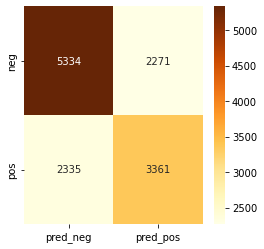

In [15]:
%%time
clf = classifyDecisionTree(features_train, labels_train, features_test, labels_test)


Adaboost with default params

In [16]:
def classifyAdaBoost(features_train, labels_train, features_test, labels_test):
    
    #create the classifer
    clf = AdaBoostClassifier(random_state=40)
    
    #fit the training data
    clf = clf.fit(features_train, labels_train)
    
    #predict the testing labels using the testing features
    pred=clf.predict(features_test)
    
    #evaluate how good the model did at predicting the true teting labels
    print(classification_report(labels_test, pred,digits=4, target_names=['unsuccessful','successful'],output_dict=False))
    
    #printing the confusion matrix
    con_mat=pd.DataFrame(confusion_matrix(labels_test, pred),  columns=['pred_neg', 'pred_pos'], index=['neg', 'pos'])
    plt.figure(figsize = (4,4))
    sn.heatmap(con_mat, annot=True,cmap='YlOrBr',fmt='g')

    return clf

the f1 score for adaboost is better than the decision tree for unsuccessful offers but performs a bit worse for successful offers.

              precision    recall  f1-score   support

unsuccessful     0.6942    0.7887    0.7384      7605
  successful     0.6552    0.5362    0.5897      5696

    accuracy                         0.6806     13301
   macro avg     0.6747    0.6624    0.6641     13301
weighted avg     0.6775    0.6806    0.6748     13301

CPU times: user 1.37 s, sys: 110 ms, total: 1.48 s
Wall time: 1.35 s


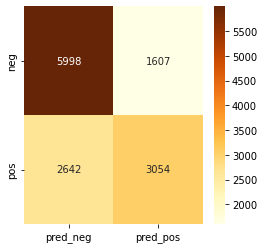

In [17]:
%%time
clf = classifyAdaBoost(features_train, labels_train, features_test, labels_test)

Random Forest with default params

In [18]:
def classifyRandomForest(features_train, labels_train, features_test, labels_test):
    
    #create the classifer
    clf = RandomForestClassifier(random_state=40)
    
    #fit the training data
    clf = clf.fit(features_train, labels_train)
    
    #predict the testing labels using the testing features
    pred=clf.predict(features_test)
    
    #evaluate how good the model did at predicting the true teting labels
    print(classification_report(labels_test, pred,digits=4, target_names=['unsuccessful','successful'],output_dict=False))
    
    #printing the confusion matrix
    con_mat=pd.DataFrame(confusion_matrix(labels_test, pred),  columns=['pred_neg', 'pred_pos'], index=['neg', 'pos'])
    plt.figure(figsize = (4,4))
    sn.heatmap(con_mat, annot=True,cmap='YlOrBr',fmt='g')

    return clf

The default random forest classifer performs comfortably better than the other two for successful offers.

              precision    recall  f1-score   support

unsuccessful     0.7220    0.7566    0.7389      7605
  successful     0.6529    0.6111    0.6313      5696

    accuracy                         0.6943     13301
   macro avg     0.6874    0.6839    0.6851     13301
weighted avg     0.6924    0.6943    0.6928     13301

CPU times: user 4.35 s, sys: 347 ms, total: 4.7 s
Wall time: 4.64 s


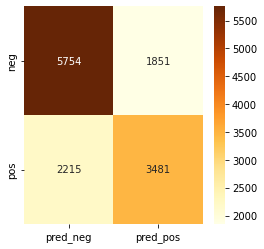

In [19]:
%%time
clf = classifyRandomForest(features_train, labels_train, features_test, labels_test)

Naive Bayes 

In [20]:
def classifyGaussianNB(features_train, labels_train, features_test, labels_test):
    
    #create the classifer
    clf = GaussianNB()
    
    #fit the training data
    clf = clf.fit(features_train, labels_train)
    
    #predict the testing labels using the testing features
    pred=clf.predict(features_test)
    
    #evaluate how good the model did at predicting the true teting labels
    print(classification_report(labels_test, pred,digits=4, target_names=['unsuccessful','successful'],output_dict=False))
    
    #printing the confusion matrix
    con_mat=pd.DataFrame(confusion_matrix(labels_test, pred),  columns=['pred_neg', 'pred_pos'], index=['neg', 'pos'])
    plt.figure(figsize = (4,4))
    sn.heatmap(con_mat, annot=True,cmap='YlOrBr',fmt='g')

    return clf

very good positive recall

              precision    recall  f1-score   support

unsuccessful     0.7170    0.6358    0.6740      7605
  successful     0.5776    0.6650    0.6182      5696

    accuracy                         0.6483     13301
   macro avg     0.6473    0.6504    0.6461     13301
weighted avg     0.6573    0.6483    0.6501     13301

CPU times: user 130 ms, sys: 82.7 ms, total: 212 ms
Wall time: 156 ms


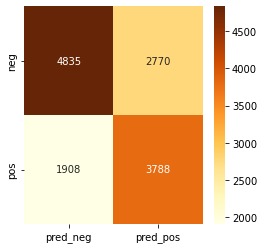

In [21]:
%%time
clf = classifyGaussianNB(features_train, labels_train, features_test, labels_test)

Support Vector Machines with default params

In [22]:
def classifySVC(features_train, labels_train, features_test, labels_test):
    
    #create the classifer
    clf = SVC()
    
    #fit the training data
    clf = clf.fit(features_train, labels_train)
    
    #predict the testing labels using the testing features
    pred=clf.predict(features_test)
    
    #evaluate how good the model did at predicting the true teting labels
    print(classification_report(labels_test, pred,digits=4, target_names=['unsuccessful','successful'],output_dict=False))
    
    #printing the confusion matrix
    con_mat=pd.DataFrame(confusion_matrix(labels_test, pred),  columns=['pred_neg', 'pred_pos'], index=['neg', 'pos'])
    plt.figure(figsize = (4,4))
    sn.heatmap(con_mat, annot=True, cmap='YlOrBr', fmt='g')

    return clf

Didnt perform as well for the successful offers. But very well for unsuccessful offers.

In [23]:
#commenting this for now as it takes about 3 minutes to run
#%%time
#clf = classifySVC(features_train, labels_train, features_test, labels_test)

<font size=4>PCA<font/>

In [24]:
scaler=QuantileTransformer()

In [25]:
features_scaled=scaler.fit_transform(features)


In [26]:
features_scaled[0]

array([0.        , 0.        , 0.        , 1.        , 1.        ,
       0.        , 0.        , 0.        , 1.        , 0.13763764,
       0.43343343, 0.64064064, 0.        , 1.        , 0.        ])

In [27]:
len(features_scaled)

66501

In [28]:
np.transpose(features_scaled)

array([[0.        , 0.        , 0.65015015, ..., 0.2997998 , 0.65015015,
        0.2997998 ],
       [0.        , 0.        , 0.2992993 , ..., 0.6986987 , 0.2992993 ,
        0.6986987 ],
       [0.        , 0.14964965, 0.2987988 , ..., 0.5985986 , 0.5985986 ,
        0.5985986 ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [29]:
pca = PCA(n_components=15)
pca.fit(np.transpose(features_scaled))

PCA(n_components=15)

In [30]:
print(pca.explained_variance_ratio_)

[2.66675755e-01 2.04596861e-01 1.70735920e-01 1.38222903e-01
 8.51866709e-02 3.62787525e-02 2.91477253e-02 2.15659897e-02
 1.96836306e-02 1.55376005e-02 6.59693555e-03 4.43130139e-03
 1.33995429e-03 2.53900175e-32 1.77311419e-32]


A common method for determining the number of PCs to be retained is a graphical representation known as a scree plot. A Scree Plot is a simple line segment plot that shows the eigenvalues for each individual PC. It shows the eigenvalues on the y-axis and the number of factors on the x-axis. It always displays a downward curve. Most scree plots look broadly similar in shape, starting high on the left, falling rather quickly, and then flattening out at some point. This is because the first component usually explains much of the variability, the next few components explain a moderate amount, and the latter components only explain a small fraction of the overall variability. The scree plot criterion looks for the “elbow” in the curve and selects all components just before the line flattens out. (In the PCA literature, the plot is called a ‘Scree’ Plot because it often looks like a ‘scree’ slope, where rocks have fallen down and accumulated on the side of a mountain.)  
https://sanchitamangale12.medium.com/scree-plot-733ed72c8608

<function matplotlib.pyplot.show(close=None, block=None)>

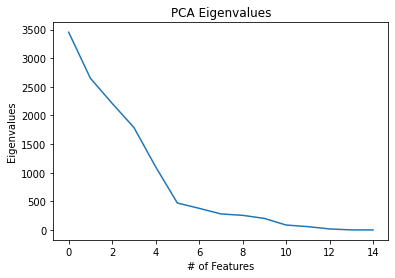

In [31]:
plt.title('PCA Eigenvalues')
plt.ylabel('Eigenvalues')
plt.xlabel('# of Features')
plt.plot(pca.explained_variance_)
plt.show

I see an elbow at 4. I will test my model with 4 pca components and see how they perform.

<function matplotlib.pyplot.show(close=None, block=None)>

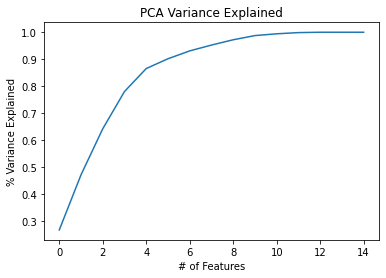

In [32]:
variance=pca.explained_variance_ratio_
var=np.cumsum(pca.explained_variance_ratio_)

plt.title('PCA Variance Explained')
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.plot(var)
plt.show

In [33]:
print("the first 4 pca components represents {:0.2f} of the variance".format(np.cumsum(pca.explained_variance_ratio_)[3]))

the first 4 pca components represents 0.78 of the variance


In [34]:
pca = PCA(n_components=4)
pca.fit(np.transpose(features_scaled))

PCA(n_components=4)

In [35]:
pca.components_

array([[-0.00171725, -0.00280834, -0.00579649, ..., -0.00245145,
        -0.00282433, -0.00245145],
       [-0.00396342, -0.00054486, -0.00362468, ...,  0.00457206,
        -0.00157998,  0.00457206],
       [ 0.00424217,  0.00358818,  0.00145135, ..., -0.00539334,
        -0.00577973, -0.00539334],
       [-0.00658256, -0.00696897,  0.00130861, ..., -0.00216815,
         0.00116608, -0.00216815]])

In [36]:
len(pca.components_)

4

In [37]:
len(np.transpose(pca.components_))

66501

In [38]:
pca_features=np.transpose(pca.components_)

In [39]:
features_train, features_test, labels_train, labels_test = train_test_split(pca_features, labels, train_size=0.80, random_state=40)

In [40]:
features_train[10]

array([-0.00517703, -0.00140144,  0.00169949,  0.00205319])

In [41]:
def classifyRandomForest(features_train, labels_train, features_test, labels_test):
    
    #create the classifer
    clf = RandomForestClassifier(random_state=40)
    
    #fit the training data
    clf = clf.fit(features_train, labels_train)
    
    #predict the testing labels using the testing features
    pred=clf.predict(features_test)
    
    #evaluate how good the model did at predicting the true teting labels
    print(classification_report(labels_test, pred,digits=4, target_names=['unsuccessful','successful'],output_dict=False))
    
    #printing the confusion matrix
    con_mat=pd.DataFrame(confusion_matrix(labels_test, pred),  columns=['pred_neg', 'pred_pos'], index=['neg', 'pos'])
    plt.figure(figsize = (4,4))
    sn.heatmap(con_mat, annot=True,cmap='YlOrBr',fmt='g')

    return clf

PCA reduction didnt appear to improve my model.

              precision    recall  f1-score   support

unsuccessful     0.7067    0.7303    0.7183      7605
  successful     0.6231    0.5953    0.6089      5696

    accuracy                         0.6725     13301
   macro avg     0.6649    0.6628    0.6636     13301
weighted avg     0.6709    0.6725    0.6715     13301

CPU times: user 12.2 s, sys: 113 ms, total: 12.3 s
Wall time: 12.2 s


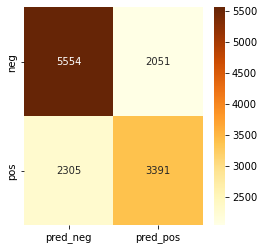

In [42]:
%%time
clf = classifyRandomForest(features_train, labels_train, features_test, labels_test)

<font size=4>Correlation<font/>

I wanted to see if any features were highly correlated. And I could remove a feature if that was the case.

In [43]:
offers_classed.columns

Index(['person', 'time', 'offer_id', 'reward', 'difficulty', 'duration',
       'successful_offer', 'mobile', 'social', 'web', 'bogo', 'discount',
       'informational', 'age', 'became_member_on', 'income', 'female', 'male',
       'other'],
      dtype='object')

In [44]:
offers_classed.filter(['reward', 'difficulty', 'duration',
       'mobile', 'social', 'web', 'bogo', 'discount',
       'informational', 'age', 'became_member_on', 'income', 'female', 'male',
       'other']).corr().round(2)

,reward,difficulty,duration,mobile,social,web,bogo,discount,informational,age,became_member_on,income,female,male,other
reward,1.00,0.47,0.16,-0.08,0.29,-0.12,0.79,-0.29,-0.62,-0.00,-0.00,0.00,0.00,0.00,-0.00
difficulty,0.47,1.00,0.81,-0.74,-0.16,0.24,-0.03,0.60,-0.70,-0.00,-0.00,-0.00,-0.00,0.00,-0.00
duration,0.16,0.81,1.00,-0.53,-0.19,0.34,-0.18,0.74,-0.68,-0.00,-0.00,-0.00,-0.00,0.00,0.00
mobile,-0.08,-0.74,-0.53,1.00,0.41,-0.17,0.27,-0.41,0.17,-0.00,0.00,0.00,-0.00,0.00,-0.00
social,0.29,-0.16,-0.19,0.41,1.00,-0.41,0.25,-0.17,-0.10,-0.00,0.00,0.00,-0.00,0.00,-0.00
web,-0.12,0.24,0.34,-0.17,-0.41,1.00,-0.10,0.41,-0.37,-0.00,0.00,-0.00,-0.00,0.00,-0.00
bogo,0.79,-0.03,-0.18,0.27,0.25,-0.10,1.00,-0.67,-0.41,-0.00,-0.00,0.00,0.00,-0.00,-0.00
discount,-0.29,0.60,0.74,-0.41,-0.17,0.41,-0.67,1.00,-0.41,-0.00,0.00,-0.00,-0.00,0.00,-0.00
informational,-0.62,-0.70,-0.68,0.17,-0.10,-0.37,-0.41,-0.41,1.00,0.01,0.00,0.00,0.00,-0.00,0.00
age,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.01,1.00,-0.01,0.31,0.15,-0.15,0.00


In [45]:
#focusing on the customer data

In [46]:
offers_classed.filter(['age', 'became_member_on', 'income', 'female', 'male',
       'other']).corr().round(2)

,age,became_member_on,income,female,male,other
age,1.00,-0.01,0.31,0.15,-0.15,0.00
became_member_on,-0.01,1.00,-0.02,0.02,-0.02,0.01
income,0.31,-0.02,1.00,0.23,-0.22,-0.01
female,0.15,0.02,0.23,1.00,-0.97,-0.10
male,-0.15,-0.02,-0.22,-0.97,1.00,-0.14
other,0.00,0.01,-0.01,-0.10,-0.14,1.00


Income and age have a 0.31 correlation. I will try out dropping income to see if the model performs better. The reason I am exploring this option is an attempt to cut down on features.

In [47]:
labels=offers_classed['successful_offer'].values

In [48]:
features = offers_classed.filter(['reward', 'difficulty', 'duration','mobile', 'social', 'web', 'bogo', 'discount',
                 'informational', 'age', 'became_member_on',   'female', 'male', 'other']).values

In [49]:
features_train, features_test, labels_train, labels_test=scale_split(features, labels)

In [50]:
def classifyRandomForest(features_train, labels_train, features_test, labels_test):
    
    #create the classifer
    clf = RandomForestClassifier(random_state=40)
    
    #fit the training data
    clf = clf.fit(features_train, labels_train)
    
    #predict the testing labels using the testing features
    pred=clf.predict(features_test)
    
    #evaluate how good the model did at predicting the true teting labels
    print(classification_report(labels_test, pred,digits=4, target_names=['unsuccessful','successful'],output_dict=False))
    
    #printing the confusion matrix
    con_mat=pd.DataFrame(confusion_matrix(labels_test, pred),  columns=['pred_neg', 'pred_pos'], index=['neg', 'pos'])
    plt.figure(figsize = (4,4))
    sn.heatmap(con_mat, annot=True,cmap='YlOrBr',fmt='g')

    return clf

removing 'income' didnt improve the model

              precision    recall  f1-score   support

unsuccessful     0.6996    0.7201    0.7097      7605
  successful     0.6111    0.5873    0.5989      5696

    accuracy                         0.6632     13301
   macro avg     0.6554    0.6537    0.6543     13301
weighted avg     0.6617    0.6632    0.6623     13301

CPU times: user 4.7 s, sys: 261 ms, total: 4.96 s
Wall time: 4.87 s


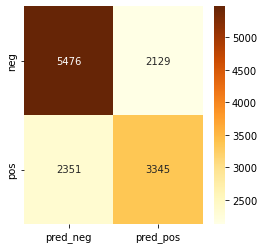

In [51]:
%%time
clf = classifyRandomForest(features_train, labels_train, features_test, labels_test)

<font size=5>GridSearchCV<font/>

https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65  
or  
https://www.kaggle.com/kevinarvai/fine-tuning-a-classifier-in-scikit-learn

First build a generic classifier and setup a parameter grid; random forests have many tunable parameters, which make it suitable for GridSearchCV. The scorers dictionary can be used as the scoring argument in GridSearchCV. When multiple scores are passed, GridSearchCV.cv_results_ will return scoring metrics for each of the score types provided.


The classifier that I feel performed best with the default parameters was the RandomForestClassifier. It had a good F1 score for the positive class while also maintaining a F1 good score for the negative class. And overall its average weight F1 score was comfortably the best. 

While it didnt have the best recall for the positive cases I think by tuning the parameters to maximise this score I can obtain a model which suits my needs even more. I hope to have a model with a good recall for the positive classes while ensuring it still performs well across the other scores. Also, the RandomForestClassifier is an ideal candiate to perform GridSearchCV on due to the fact that it has many tuneable parameters.

Resetting the features and labels

In [ ]:

clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5),random_state=42)
parameters = {'n_estimators':[5,10,15,20,25],'learning_rate':[1,0.1,0.01,0.001]}
scorer = recall_score(y_train, y_pred)
grid_obj = GridSearchCV(clf, parameters, scorer)
grid_fit = grid_obj.fit(X_train, y_train)
best_clf = grid_fit.best_estimator_
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

In [13]:
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5),random_state=42)

In [20]:
#Benjamin
clf = clf.fit(features_train, labels_train)


In [21]:
#Benjamin
pred=clf.predict(features_test)

In [22]:
parameters = {'n_estimators':[5,10,15,20,25],'learning_rate':[1,0.1,0.01,0.001]}

In [23]:
pred=clf.predict(features_test)

In [25]:
scorer = recall_score(labels_test, pred)

In [26]:
grid_obj = GridSearchCV(clf, parameters, scorer)

/home/benjamin/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass scoring=0.5881320224719101 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [28]:
grid_fit = grid_obj.fit(features_train,labels_train)
best_clf = grid_fit.best_estimator_
predictions = (clf.fit(features_train,labels_train)).predict(features_test)
best_predictions = best_clf.predict(features_test)

ValueError: scoring is invalid (got 0.5881320224719101). Refer to the scoring glossary for details: https://scikit-learn.org/stable/glossary.html#term-scoring

my GridSearchCV

In [52]:
features_train

array([[0.65065065, 0.2997998 , 0.2987988 , ..., 0.        , 1.        ,
        0.        ],
       [0.65065065, 0.2997998 , 0.5985986 , ..., 1.        , 0.        ,
        0.        ],
       [0.2997998 , 0.6996997 , 0.5985986 , ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.15015015, ..., 0.        , 1.        ,
        0.        ],
       [1.        , 0.6996997 , 0.2987988 , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ]])

In [53]:
features = offers_classed.filter(['reward', 'difficulty', 'duration','mobile', 'social', 'web', 'bogo', 'discount',
                 'informational', 'age', 'became_member_on', 'income',   'female', 'male', 'other']).values

labels=offers_classed['successful_offer'].values
labels=labels.astype(bool)

features_train, features_test, labels_train, labels_test=scale_split(features, labels)

In [54]:
#skf = StratifiedKFold(n_splits=10)
#setting to 5 temporarily
skf = StratifiedKFold(n_splits=5)


In [55]:
param_grid={'max_features': ['auto', 'sqrt',],
                'max_depth' : [5,20,None],
                'n_estimators': [10,50,100],
                'min_samples_leaf': [1,2, 20],
               }

In [97]:
param_grid={'criterion': ['gini', 'entropy'],
            'max_depth': [5, 15, None],
            'max_features': ['auto', 'sqrt','log2'],
            'min_samples_leaf': [1, 3, 5, 10, 20],
            'min_samples_split': [2, 3, 5, 10, 20],
            'n_estimators': [10, 25, 50, 100, 300]}





#This took 4h 45min 57s for only 5 folds
#so would take 9.5 hours for 10 folds

In [ ]:
param_grid={'criterion': ['gini', 'entropy'],
            #'max_depth': [5, 15, None],
            #'max_features': ['auto', 'sqrt','log2'],
            'min_samples_leaf': [1, 3, 5, 10, 20],
            'min_samples_split': [2, 5, 10, 20, 25],
            'n_estimators': [10, 25, 100, 300, 400]}

In [119]:
grid_search = GridSearchCV(RandomForestClassifier(random_state=40), param_grid, refit='recall_binary', n_jobs = -1, verbose=5,cv=skf)

In [56]:
grid_search = GridSearchCV(RandomForestClassifier(random_state=40), param_grid, scoring='f1_binary', n_jobs = -1, verbose=5,cv=skf)

In [57]:
%%time

grid_search.fit(features_train, labels_train)

ValueError: 'f1_binary' is not a valid scoring value. Use sorted(sklearn.metrics.SCORERS.keys()) to get valid options.

In [ ]:
#Fitting the big daddy

Fitting 5 folds for each of 2250 candidates, totalling 11250 fits
CPU times: user 1min 55s, sys: 10.2 s, total: 2min 6s
Wall time: 4h 45min 57s
GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(random_state=40), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 15, None],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 3, 5, 10, 20],
                         'min_samples_split': [2, 3, 5, 10, 20],
                         'n_estimators': [10, 25, 50, 100, 300]},
             refit='recall_binary', verbose=5)

#results for grid_search.best_params_
{'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 20,
 'n_estimators': 300}

In [148]:
grid_search.best_params_

{'max_depth': 20,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'n_estimators': 100}

In [ ]:
#max_depth=20,max_features='auto',min_samples_leaf=20,n_estimators=50

In [144]:
#Enter the paremters from the grid search that maxmised recall for the positive class
def classifyRandomForestRecall(features_train, labels_train, features_test, labels_test):
    
    #create the classifer
    clf = RandomForestClassifier(random_state=40, max_depth=None,max_features='auto',min_samples_leaf=20, n_estimators=100)
    #clf = RandomForestClassifier(random_state=40)
    #fit the training data
    clf = clf.fit(features_train, labels_train)
    
    #predict the testing labels using the testing features
    pred=clf.predict(features_test)
    
    #evaluate how good the model did at predicting the true teting labels
    print(classification_report(labels_test, pred,digits=4, target_names=['unsuccessful','successful'],output_dict=False))
    
    #printing the confusion matrix
    con_mat=pd.DataFrame(confusion_matrix(labels_test, pred),  columns=['pred_neg', 'pred_pos'], index=['neg', 'pos'])
    plt.figure(figsize = (4,4))
    sn.heatmap(con_mat, annot=True,cmap='YlOrBr',fmt='g')

    return clf

In [ ]:
        precision    recall  f1-score   support

unsuccessful     0.9703    0.9747    0.9725     30458
  successful     0.9659    0.9601    0.9630     22742

    accuracy                         0.9685     53200
   macro avg     0.9681    0.9674    0.9678     53200
weighted avg     0.9684    0.9685    0.9684     53200

              precision    recall  f1-score   support

unsuccessful     0.7340    0.8336    0.7806     30458
  successful     0.7277    0.5953    0.6549     22742

    accuracy                         0.7318     53200
   macro avg     0.7308    0.7145    0.7178     53200
weighted avg     0.7313    0.7318    0.7269     53200

CPU times: user 3.16 s, sys: 67.3 ms, total: 3.23 s
Wall time: 3.18 s


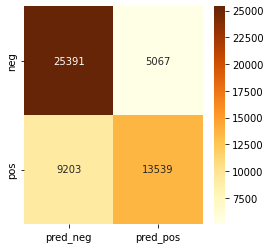

In [145]:
%%time
clf = classifyRandomForestRecall(features_train, labels_train, features_train, labels_train)

In [133]:
             precision    recall  f1-score   support

unsuccessful     0.9689    0.9762    0.9726     30458
  successful     0.9678    0.9581    0.9629     22742

    accuracy                         0.9685     53200
   macro avg     0.9684    0.9672    0.9678     53200
weighted avg     0.9685    0.9685    0.9685     53200


IndentationError: unindent does not match any outer indentation level (<tokenize>, line 7)

In [ ]:
              precision    recall  f1-score   support

unsuccessful     0.7220    0.7566    0.7389      7605
  successful     0.6529    0.6111    0.6313      5696

    accuracy                         0.6943     13301
   macro avg     0.6874    0.6839    0.6851     13301
weighted avg     0.6924    0.6943    0.6928     13301

In [11]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

In [12]:
X_train, X_test, y_train, y_test=scale_split(features, labels)

In [23]:


%%time

# Set the parameters by cross-validation
tuned_parameters = [{'max_features': ['auto'],
                'min_samples_leaf': [19, 20,21]}]


scores = ['precision', 'recall']
#scores = ['f1']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        RandomForestClassifier(), tuned_parameters, scoring='%s_macro' % score
    )
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Note the problem is too easy: the hyperparameter plateau is too flat and the
# output model is the same for precision and recall with ties in quality.

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'max_features': 'auto', 'min_samples_leaf': 20}

Grid scores on development set:

0.696 (+/-0.013) for {'max_features': 'auto', 'min_samples_leaf': 19}
0.696 (+/-0.012) for {'max_features': 'auto', 'min_samples_leaf': 20}
0.695 (+/-0.013) for {'max_features': 'auto', 'min_samples_leaf': 21}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

         0.0       0.71      0.81      0.76      7605
         1.0       0.69      0.55      0.61      5696

    accuracy                           0.70     13301
   macro avg       0.70      0.68      0.68     13301
weighted avg       0.70      0.70      0.69     13301


# Tuning hyper-parameters for recall

Best parameters set found on development set:

{'max_features': 'auto', 'min_samples_leaf': 19}

Grid scores on deve

In [26]:


%%time

# Set the parameters by cross-validation
tuned_parameters = [{'max_features': ['auto'],
                'min_samples_leaf': [19, 20,21]}]


scores = ['precision', 'recall']
#scores = ['f1']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        RandomForestClassifier(), tuned_parameters, scoring=score#scoring='%s_macro' % score
    )
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Note the problem is too easy: the hyperparameter plateau is too flat and the
# output model is the same for precision and recall with ties in quality.

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'max_features': 'auto', 'min_samples_leaf': 19}

Grid scores on development set:

0.684 (+/-0.016) for {'max_features': 'auto', 'min_samples_leaf': 19}
0.684 (+/-0.017) for {'max_features': 'auto', 'min_samples_leaf': 20}
0.683 (+/-0.016) for {'max_features': 'auto', 'min_samples_leaf': 21}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

         0.0       0.71      0.81      0.76      7605
         1.0       0.69      0.55      0.61      5696

    accuracy                           0.70     13301
   macro avg       0.70      0.68      0.69     13301
weighted avg       0.70      0.70      0.70     13301


# Tuning hyper-parameters for recall

Best parameters set found on development set:

{'max_features': 'auto', 'min_samples_leaf': 20}

Grid scores on deve

In [18]:
from sklearn.metrics import f1_score, make_scorer

f1 = make_scorer(f1_score , average='binary')

In [25]:
recall=make_scorer(averaging='binary', pos_label=1)

NameError: name 'kwargs' is not defined

In [13]:
features_train, features_test, labels_train, labels_test=scale_split(features, labels)
features_train[0]

array([0.65065065, 0.2997998 , 0.2987988 , 1.        , 1.        ,
       1.        , 1.        , 0.        , 0.        , 0.2032032 ,
       0.98498498, 0.54004004, 0.        , 1.        , 0.        ])

In [13]:
X_train, X_test, y_train, y_test=scale_split(features, labels)

In [17]:
from sklearn.metrics import recall_score
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5),random_state=42)
parameters = {'n_estimators':[5,10,15,20,25],'learning_rate':[1,0.1,0.01,0.001]}
scorer = recall_score(y_train, y_pred)

NameError: name 'y_pred' is not defined

In [18]:
grid_obj = GridSearchCV(clf, parameters, scorer)
grid_fit = grid_obj.fit(X_train, y_train)
best_clf = grid_fit.best_estimator_

NameError: name 'scorer' is not defined

In [19]:
y_pred=clf.predict(y_test)

ValueError: Expected 2D array, got 1D array instead:
array=[0. 0. 0. ... 0. 1. 0.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
from sklearn.metrics import recall_score
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5),random_state=42)
parameters = {'n_estimators':[5,10,15,20,25],'learning_rate':[1,0.1,0.01,0.001]}
scorer = recall_score(y_train, y_pred)
grid_obj = GridSearchCV(clf, parameters, scorer)
grid_fit = grid_obj.fit(X_train, y_train)
best_clf = grid_fit.best_estimator_
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

In [1]:
#>>> import numpy as np
#>>> def my_custom_loss_func(y_true, y_pred):
#...     diff = np.abs(y_true - y_pred).max()
#...     return np.log1p(diff)
#...
#>>> # score will negate the return value of my_custom_loss_func,
#>>> # which will be np.log(2), 0.693, given the values for X
#>>> # and y defined below.
#>>> score = make_scorer(my_custom_loss_func, greater_is_better=False)
#>>> X = [[1], [1]]
#>>> y = [0, 1]
#>>> from sklearn.dummy import DummyClassifier
#>>> clf = DummyClassifier(strategy='most_frequent', random_state=0)
#>>> clf = clf.fit(X, y)
#>>> my_custom_loss_func(y, clf.predict(X))
#0.69...
#>>> score(clf, X, y)
#-0.69...

<font size=4>Refinement with new features<font>

In [104]:
offers_classed_nf=pd.read_pickle("final_table_nf.pkl")

In [105]:
offers_classed_nf.head()

,person,time,offer_id,reward,difficulty,duration,successful_offer,mobile,social,web,...,became_member_on,income,female,male,other,total_spend,transaction,completed,received,viewed
0,0009655768c64bdeb2e877511632db8f,168.0,5a8bc65990b245e5a138643cd4eb9837,0.0,0.0,3.0,1.0,1.0,1.0,0.0,...,1492732800000000000,72000.0,0,1,0,0.00,0,0,1,0
1,0009655768c64bdeb2e877511632db8f,336.0,3f207df678b143eea3cee63160fa8bed,0.0,0.0,4.0,1.0,1.0,0.0,1.0,...,1492732800000000000,72000.0,0,1,0,22.16,1,0,2,1
2,0009655768c64bdeb2e877511632db8f,408.0,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,5.0,0.0,1.0,1.0,1.0,...,1492732800000000000,72000.0,0,1,0,22.16,1,0,3,2
3,0009655768c64bdeb2e877511632db8f,504.0,fafdcd668e3743c1bb461111dcafc2a4,2.0,10.0,10.0,0.0,1.0,1.0,1.0,...,1492732800000000000,72000.0,0,1,0,30.73,2,1,4,3
4,0009655768c64bdeb2e877511632db8f,576.0,2906b810c7d4411798c6938adc9daaa5,2.0,10.0,7.0,0.0,1.0,0.0,1.0,...,1492732800000000000,72000.0,0,1,0,58.40,4,2,5,4


In [106]:
labels=offers_classed_nf['successful_offer'].values
print(len(labels))

66501


In [199]:
features_nf = offers_classed_nf.filter(['reward', 'difficulty', 'duration','mobile', 'social', 'web', 'bogo', 'discount',
                 'informational', 'age', 'became_member_on', 'income',   'female', 'male', 'other','total_spend','transaction','completed','received','viewed']).values
#,'transaction','completed','received','viewed'
print(len(features))

66501


In [200]:
features_train, features_test, labels_train, labels_test=scale_split(features_nf, labels)
features_train[31]

array([1.        , 0.6996997 , 0.2987988 , 1.        , 1.        ,
       1.        , 1.        , 0.        , 0.        , 0.28528529,
       0.07564708, 0.39339339, 0.        , 1.        , 0.        ,
       0.44264264, 0.87837838, 0.64614615, 0.55105105, 0.68668669])

In [201]:




def classifyRandomForest(features_train, labels_train, features_test, labels_test):
    
    #create the classifer
    clf = RandomForestClassifier(random_state=40)
    
    #fit the training data
    clf = clf.fit(features_train, labels_train)
    
    #predict the testing labels using the testing features
    pred=clf.predict(features_test)
    
    #evaluate how good the model did at predicting the true teting labels
    print(classification_report(labels_test, pred,digits=4, target_names=['unsuccessful','successful'],output_dict=False))
    
    #printing the confusion matrix
    con_mat=pd.DataFrame(confusion_matrix(labels_test, pred),  columns=['pred_neg', 'pred_pos'], index=['neg', 'pos'])
    plt.figure(figsize = (4,4))
    sn.heatmap(con_mat, annot=True,cmap='YlOrBr',fmt='g')

    return clf


              precision    recall  f1-score   support

unsuccessful     0.7310    0.7824    0.7558      7605
  successful     0.6794    0.6157    0.6460      5696

    accuracy                         0.7110     13301
   macro avg     0.7052    0.6990    0.7009     13301
weighted avg     0.7089    0.7110    0.7088     13301

CPU times: user 9.82 s, sys: 59.2 ms, total: 9.88 s
Wall time: 9.81 s


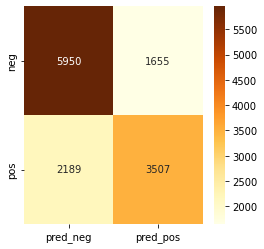

In [202]:

%%time
clf = classifyRandomForest(features_train, labels_train, features_test, labels_test)

Original evaluation grid was like this:

In [141]:
#              precision    recall  f1-score   support
#
#unsuccessful     0.7220    0.7566    0.7389      7605
#  successful     0.6529    0.6111    0.6313      5696

#    accuracy                         0.6943     13301
#   macro avg     0.6874    0.6839    0.6851     13301
#weighted avg     0.6924    0.6943    0.6928     13301

PCA with new features

In [163]:
scaler=QuantileTransformer()

In [164]:
features_scaled=scaler.fit_transform(features_nf)

In [165]:
features_scaled[0]

array([0.        , 0.        , 0.        , 1.        , 1.        ,
       0.        , 0.        , 0.        , 1.        , 0.13763764,
       0.43343343, 0.64064064, 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [166]:
len(features_scaled)

66501

In [168]:
pca = PCA(n_components=15)
pca.fit(np.transpose(features_scaled))

PCA(n_components=15)

In [169]:
print(pca.explained_variance_ratio_)


[0.23505007 0.1722026  0.14491784 0.12376264 0.10041156 0.07070842
 0.0332527  0.02639689 0.01876337 0.01804988 0.01593371 0.0134433
 0.01054003 0.00554436 0.00407936]


<function matplotlib.pyplot.show(close=None, block=None)>

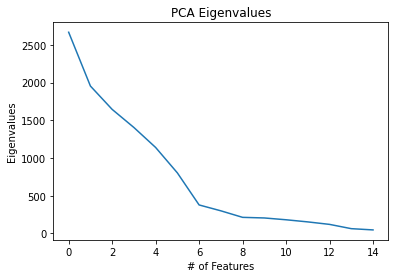

In [170]:

plt.title('PCA Eigenvalues')
plt.ylabel('Eigenvalues')
plt.xlabel('# of Features')
plt.plot(pca.explained_variance_)
plt.show

The elbow is after 6 features

<function matplotlib.pyplot.show(close=None, block=None)>

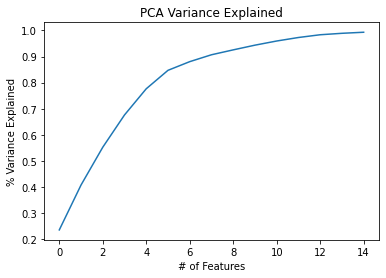

In [173]:
variance=pca.explained_variance_ratio_
var=np.cumsum(pca.explained_variance_ratio_)

plt.title('PCA Variance Explained')
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.plot(var)
plt.show

In [2]:
print("the first 4 pca components represents {:0.2f} of the variance".format(np.cumsum(pca.explained_variance_ratio_)[5]))


NameError: name 'np' is not defined

In [175]:
pca = PCA(n_components=6)
pca.fit(np.transpose(features_scaled))

PCA(n_components=6)

In [176]:
pca_features=np.transpose(pca.components_)

In [177]:
features_train, features_test, labels_train, labels_test = train_test_split(pca_features, labels, train_size=0.80, random_state=40)

features_train[10]

array([-0.00434793, -0.00173342,  0.00236769, -0.00068764, -0.00558476,
       -0.00558426])

In [178]:
def classifyRandomForest(features_train, labels_train, features_test, labels_test):
    
    #create the classifer
    clf = RandomForestClassifier(random_state=40)
    
    #fit the training data
    clf = clf.fit(features_train, labels_train)
    
    #predict the testing labels using the testing features
    pred=clf.predict(features_test)
    
    #evaluate how good the model did at predicting the true teting labels
    print(classification_report(labels_test, pred,digits=4, target_names=['unsuccessful','successful'],output_dict=False))
    
    #printing the confusion matrix
    con_mat=pd.DataFrame(confusion_matrix(labels_test, pred),  columns=['pred_neg', 'pred_pos'], index=['neg', 'pos'])
    plt.figure(figsize = (4,4))
    sn.heatmap(con_mat, annot=True,cmap='YlOrBr',fmt='g')

    return clf

              precision    recall  f1-score   support

unsuccessful     0.6950    0.7435    0.7184      7605
  successful     0.6223    0.5644    0.5920      5696

    accuracy                         0.6668     13301
   macro avg     0.6587    0.6539    0.6552     13301
weighted avg     0.6639    0.6668    0.6643     13301

CPU times: user 12.5 s, sys: 38.6 ms, total: 12.6 s
Wall time: 12.5 s


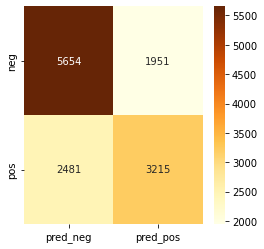

In [179]:
%%time
clf = classifyRandomForest(features_train, labels_train, features_test, labels_test)


Again, PCA reduction does not show an apparent improvment using the default decision tree parameters.

Checking correlations

In [185]:
offers_classed_nf.filter(['age', 'became_member_on', 'income', 'female', 'male',
       'other','total_spend','transaction','completed','received','viewed']).corr().round(2)

,age,became_member_on,income,female,male,other,total_spend,transaction,completed,received,viewed
age,1.00,-0.01,0.31,0.15,-0.15,0.00,0.06,-0.09,0.06,-0.00,0.01
became_member_on,-0.01,1.00,-0.02,0.02,-0.02,0.01,-0.11,-0.25,-0.13,-0.00,-0.01
income,0.31,-0.02,1.00,0.23,-0.22,-0.01,0.21,-0.15,0.15,-0.00,0.03
female,0.15,0.02,0.23,1.00,-0.97,-0.10,0.10,-0.03,0.10,-0.00,0.01
male,-0.15,-0.02,-0.22,-0.97,1.00,-0.14,-0.10,0.03,-0.11,0.00,-0.01
other,0.00,0.01,-0.01,-0.10,-0.14,1.00,0.00,0.00,0.01,-0.01,0.01
total_spend,0.06,-0.11,0.21,0.10,-0.10,0.00,1.00,0.52,0.59,0.38,0.41
transaction,-0.09,-0.25,-0.15,-0.03,0.03,0.00,0.52,1.00,0.63,0.60,0.59
completed,0.06,-0.13,0.15,0.10,-0.11,0.01,0.59,0.63,1.00,0.61,0.63
received,-0.00,-0.00,-0.00,-0.00,0.00,-0.01,0.38,0.60,0.61,1.00,0.86


Income is correlated somewhat with total_spend as I would expect.

honing in on my the new features

In [228]:
display(offers_classed_nf.filter(['total_spend','transaction','completed','received','viewed']).corr().round(2))
display(offers_classed_nf.filter(['total_spend','transaction','completed','received','viewed']).corr().round(2).sum())

,total_spend,transaction,completed,received,viewed
total_spend,1.00,0.52,0.59,0.38,0.41
transaction,0.52,1.00,0.63,0.60,0.59
completed,0.59,0.63,1.00,0.61,0.63
received,0.38,0.60,0.61,1.00,0.86
viewed,0.41,0.59,0.63,0.86,1.00


total_spend    2.90
transaction    3.34
completed      3.46
received       3.45
viewed         3.49
dtype: float64

I see some pretty strong correlations between the events and the total spend. I tested out some models with some of the new features removed. I saw a slight degradation with 'viewed' or 'received' were removed. 

I can see 'total_spent' is quite highly correlated with transactions and completed offers (as expected). It is slightly less correlated with received and viewed offers, but still signifcantly correlated (as expected).

I will test out a default random forest with the events (transaction, completed, received, viewed) removed.  
I can see that viewed is particularly highly correlated with completed and received (the highest two in the grid). So I will leave in viewed and remove completed and received.

In [241]:
features_nf = offers_classed_nf.filter(['reward', 'difficulty', 'duration','mobile', 'social', 'web', 'bogo', 'discount',
                 'informational', 'age', 'became_member_on', 'income', 'female', 'male', 'other','total_spend','transaction','viewed']).values
#'completed','received'
print(len(features))

66501


In [242]:
features_train, features_test, labels_train, labels_test=scale_split(features_nf, labels)
features_train[31]

array([1.        , 0.6996997 , 0.2987988 , 1.        , 1.        ,
       1.        , 1.        , 0.        , 0.        , 0.28528529,
       0.07564708, 0.39339339, 0.        , 1.        , 0.        ,
       0.44264264, 0.87837838, 0.68668669])

In [243]:
def classifyRandomForest(features_train, labels_train, features_test, labels_test):
    
    #create the classifer
    clf = RandomForestClassifier(random_state=40)
    
    #fit the training data
    clf = clf.fit(features_train, labels_train)
    
    #predict the testing labels using the testing features
    pred=clf.predict(features_test)
    
    #evaluate how good the model did at predicting the true teting labels
    print(classification_report(labels_test, pred,digits=4, target_names=['unsuccessful','successful'],output_dict=False))
    
    #printing the confusion matrix
    con_mat=pd.DataFrame(confusion_matrix(labels_test, pred),  columns=['pred_neg', 'pred_pos'], index=['neg', 'pos'])
    plt.figure(figsize = (4,4))
    sn.heatmap(con_mat, annot=True,cmap='YlOrBr',fmt='g')

    return clf

In [ ]:
#with all new features it was this
#              precision    recall  f1-score   support

#unsuccessful     0.7310    0.7824    0.7558      7605
#  successful     0.6794    0.6157    0.6460      5696

#    accuracy                         0.7110     13301
#   macro avg     0.7052    0.6990    0.7009     13301
#weighted avg     0.7089    0.7110    0.7088     13301


I can see a slight degradation in the weighted f1-score of less than 0.2%  
I can see a slight degradation in the overall accuracy which is also less than 0.2%

              precision    recall  f1-score   support

unsuccessful     0.7296    0.7825    0.7551      7605
  successful     0.6785    0.6127    0.6439      5696

    accuracy                         0.7098     13301
   macro avg     0.7040    0.6976    0.6995     13301
weighted avg     0.7077    0.7098    0.7075     13301

CPU times: user 8.61 s, sys: 69.3 ms, total: 8.68 s
Wall time: 8.61 s


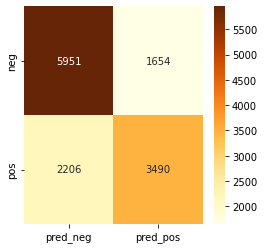

In [244]:
%%time
clf = classifyRandomForest(features_train, labels_train, features_test, labels_test)

I can see a slight degradation in the weighted f1-score of less than 0.2%  
I can see a slight degradation in the overall accuracy which is also less than 0.2%

I will remove the new features 'completed' & 'received' in order to try and stem the risk of overfitting my model

<font size=4>GridSearchCV with new features<font/>

In [ ]:
features_nf = offers_classed_nf.filter(['reward', 'difficulty', 'duration','mobile', 'social', 'web', 'bogo', 'discount',
                 'informational', 'age', 'became_member_on', 'income', 'female', 'male', 'other','total_spend','transaction','viewed']).values

labels=offers_classed_nf['successful_offer'].values

In [ ]:
features_train, features_test, labels_train, labels_test=scale_split(features_nf, labels)

In [ ]:
#skf = StratifiedKFold(n_splits=10)
#setting to 4 temporarily
skf = StratifiedKFold(n_splits=4)


In [ ]:
param_grid={'max_features': ['auto', 'sqrt',],
                'max_depth' : [5,20],
                'n_estimators': [10,50],
                'min_samples_leaf': [2, 20],
               }

In [ ]:
param_grid={'criterion': ['gini', 'entropy'],
            'max_depth': [5, 10, 15, 20],
            'max_features': ['auto', 'sqrt','log2'],
            'min_samples_leaf': [2, 3, 5, 10, 20],
            'min_samples_split': [2, 3, 5, 10, 20],
            'n_estimators': [10, 25, 50, 100, 300]}

In [ ]:
grid_search = GridSearchCV(RandomForestClassifier(random_state=40), param_grid, refit='recall_binary', n_jobs = -1, verbose=5,cv=skf)

In [ ]:
%%time

grid_search.fit(features_train, labels_train)

In [ ]:
#Enter the paremters from the grid search that maxmised recall for the positive class
def classifyRandomForestRecallNF(features_train, labels_train, features_test, labels_test):
    
    #create the classifer
    clf = RandomForestClassifier(random_state=40)
    
    #fit the training data
    clf = clf.fit(features_train, labels_train)
    
    #predict the testing labels using the testing features
    pred=clf.predict(features_test)
    
    #evaluate how good the model did at predicting the true teting labels
    print(classification_report(labels_test, pred,digits=4, target_names=['unsuccessful','successful'],output_dict=False))
    
    #printing the confusion matrix
    con_mat=pd.DataFrame(confusion_matrix(labels_test, pred),  columns=['pred_neg', 'pred_pos'], index=['neg', 'pos'])
    plt.figure(figsize = (4,4))
    sn.heatmap(con_mat, annot=True,cmap='YlOrBr',fmt='g')

    return clf

In [ ]:
%%time
clf = classifyRandomForestRecallNF(features_train, labels_train)